In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import random
import numpy as np
import faiss
from surprise import Dataset, Reader, SVD
from sklearn.metrics import f1_score
import joblib
import csv
import os
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from surprise import accuracy


# Знакомство с датасетом

In [ ]:
# задаю пути к файлам с логами и видео-статистикой
file1 = 'logs_df_2024-08-05.parquet'
file2 = 'logs_df_2024-08-06.parquet'
file3 = 'video_stat.parquet'

# загружаю данные из каждого файла формата .parquet
df1 = pd.read_parquet(file1)
df2 = pd.read_parquet(file2)
df3 = pd.read_parquet(file3)

# для проверки данных, вывожу первые несколько строк из каждого загруженного dataframe
print(df1.head())
print(df2.head())
print(df3.head())

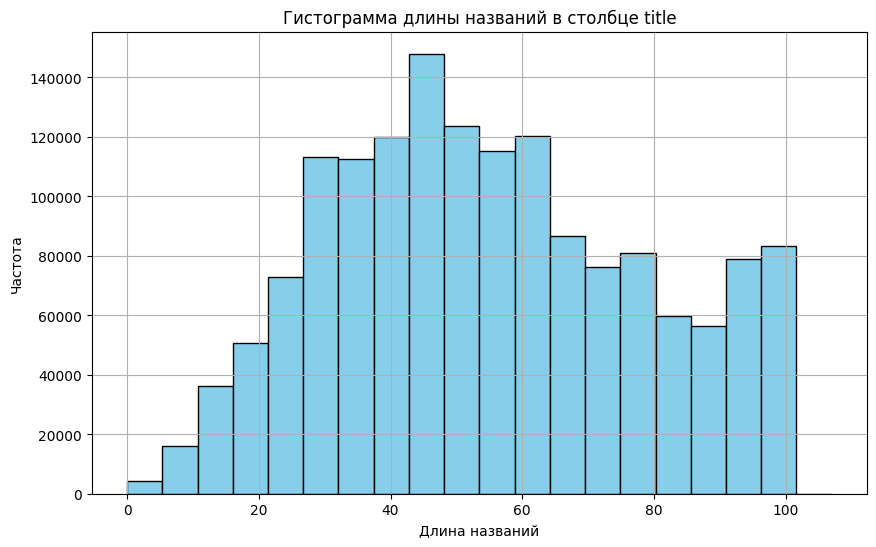

In [2]:
# подсчет длины названий в столбце 'title'
df3['title_length'] = df3['title'].str.len()

# построим гистограмму длины названий
plt.figure(figsize=(10, 6))
plt.hist(df3['title_length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Гистограмма длины названий в столбце title')
plt.xlabel('Длина названий')
plt.ylabel('Частота')
plt.grid(True)

# отобразим график
plt.show()


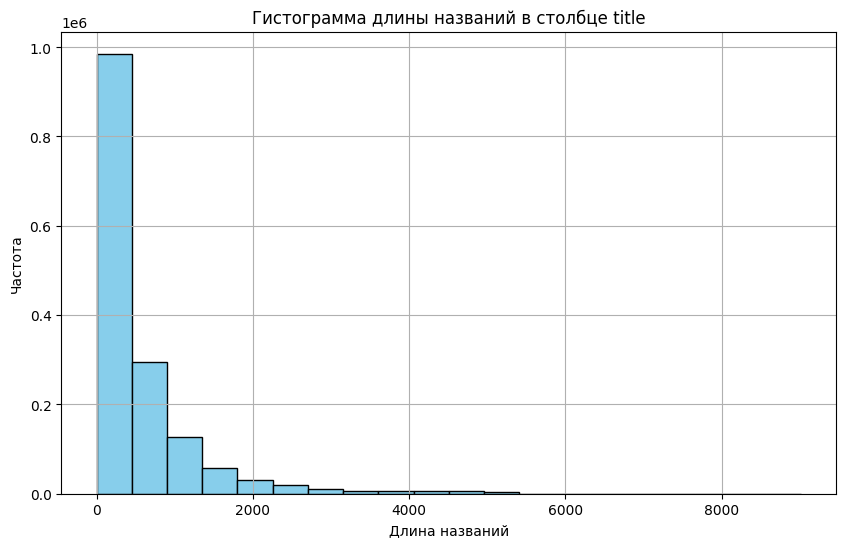

In [3]:

# подсчет длины описаний в столбце 'description'
df3['title_length'] = df3['description'].str.len()

# Построим гистограмму длины названий
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df3['title_length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Гистограмма длины названий в столбце description')
plt.xlabel('Длина названий')
plt.ylabel('Частота')
plt.grid(True)

# тобразим график
plt.show()

# Создаем эмбединги для текста

In [ ]:
# подтягиваем модель и токенайзер
model_name = 'cointegrated/rubert-tiny2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# чекаем, есть ли gpu, и если да — кидаем модель на него
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# задаем максимальные размеры для title и description
max_length_title = 100
max_length_description = 512  # можно закинуть и 1024, если ресурсов хватает

# функция для выцепления эмбеддингов, юзаем gpu если есть
def get_embeddings(texts, max_length):
    texts = texts.astype(str).tolist()  # кастим в строки и потом в список
    embeddings = []
    
    for text in tqdm(texts, desc="Processing texts"):
        tokens = tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'  # юзаем тензоры для pytorch
        ).to(device)  # отправляем на gpu
        
        with torch.no_grad():  # отключаем градиенты для буста производительности
            outputs = model(**tokens)

        # выцепляем эмбеддинги 
        embedding = outputs.last_hidden_state.mean(dim=1)  # усредняем по токенам, чтобы получить один эмбед на текст
        embeddings.append(embedding.cpu().numpy())  # возвращаем обратно на cpu и кидаем в лист
    
    return embeddings


# генерим эмбеддинги для title и description на gpu
df3['title_embeddings'] = list(get_embeddings(df3['title'], max_length_title))
df3['description_embeddings'] = list(get_embeddings(df3['description'], max_length_description))

# чекаем что получилось
df3.to_pickle('embeddings.pkl')
print(df3.head())

In [88]:
# загружаем dataframe из pickle файла
df = pd.read_pickle('embeddings.pkl')

# чекаем, что за данные подтянулись
print(df.head())

                               video_id            v_pub_datetime  \
0  973f24c0-15b2-434f-8740-4e2726f79c30 2024-06-15 22:58:03+03:00   
1  1a3f527c-44b2-4f7e-9641-26f078edbf2e 2021-04-18 17:27:42+03:00   
2  2f563d09-45ef-4e27-8da0-daa74235a2e7 2022-11-17 16:36:43+03:00   
3  154fac0e-1794-4406-afa0-61f688e3a764 2010-01-01 00:00:01+03:00   
4  470b4e3e-e06d-4370-80dc-34d6a78b22db 2023-11-29 16:49:46+03:00   

   v_total_comments  v_year_views  v_month_views  v_week_views  v_day_views  \
0                 0           556              2             0            0   
1                 0           109              2             1            0   
2                 0           163              2             2            0   
3                 0         10657           5227          1300          202   
4                 0           154             45            13            1   

   v_likes  v_dislikes  v_duration  ...  v_long_views_1_days  \
0        0           0       7.733  ...       

# выбираем видео для первого показа


In [35]:
# делаем копию df для дальнейших расчетов
df_copy = df.copy()

# метрики, которые будем юзать для ранжирования
metrics = [
    'v_year_views', 'v_month_views', 'v_week_views', 'v_day_views',
    'v_total_comments', 'v_likes', 'v_dislikes', 'v_long_views_1_days', 'v_long_views_7_days', 'v_long_views_30_days',
    'v_avg_watchtime_1_day', 'v_avg_watchtime_7_day', 'v_avg_watchtime_30_day'
]

# нормализуем метрики (приводим к одному масштабу)
scaler = MinMaxScaler()
df_copy[metrics] = scaler.fit_transform(df_copy[metrics])

# веса для каждой метрики (подстраивай как надо)
weights = {
    'v_year_views': 0.1, 'v_month_views': 0.2, 'v_week_views': 0.2, 'v_day_views': 0.1,
    'v_total_comments': 0.05, 'v_likes': 0.1, 'v_dislikes': -0.05,
    'v_long_views_1_days': 0.05, 'v_long_views_7_days': 0.05, 'v_long_views_30_days': 0.05,
    'v_avg_watchtime_1_day': 0.05, 'v_avg_watchtime_7_day': 0.05, 'v_avg_watchtime_30_day': 0.05
}

# считаем финальный рейтинг для каждого видео
df_copy['video_score'] = 0
for metric, weight in weights.items():
    df_copy['video_score'] += df_copy[metric] * weight

# категории, по которым будем выцеплять топ-20 видосов
categories = {
    'Разное': 0.308092,
    'Сериалы': 0.061737,
    'Телепередачи': 0.060987,
    'Видеоигры': 0.055728,
    'Музыка': 0.049934,
    'Развлечения': 0.049611,
    'Фильмы': 0.038776,
    'Лайфстайл': 0.032420,
    'Детям': 0.031155,
    'Обучение': 0.031137
}

# для каждой категории отбираем топ-20 видео и сохраняем их в csv
for category_name, _ in categories.items():
    # фильтруем данные по категории
    df_category_copy = df_copy[df_copy['category_id'] == category_name]
    
    # если в категории меньше 20 видео, берем все что есть
    top_videos_category_copy = df_category_copy.sort_values(by='video_score', ascending=False).head(20)
    
    # находим индексы топовых видосов
    top_videos_indices = top_videos_category_copy.index
    
    # по этим индексам достаем оригинальные данные из исходного df
    top_videos_original = df.loc[top_videos_indices]
    
    # сохраняем оригинальные данные в csv для каждой категории (без 'video_score')
    top_videos_original.to_csv(f'top_20_videos_{category_name}.csv', index=False)
    
    # выводим список топ-20 для каждой категории (без 'video_score')
    top_20_list = top_videos_original[['video_id', 'title']].head(20).to_dict(orient='records')
    print(f"топ-20 видео для категории {category_name}:")
    print(top_20_list)



Топ-20 видео для категории Разное:
[{'video_id': 'da0d4bc2-d904-4d16-871d-e3134e8b3ed2', 'title': 'Украинский фронт - атака ВСУ на Суджу. Украинские войска бегут из КОТЛА. 6 августа 2024'}, {'video_id': 'e1483f15-2a30-4b28-a909-d710259d3303', 'title': 'RTX 5000: ждать или бежать в магазин? RTX 5090 без «мускул» и реформа AMD. Игровые новости и кино'}, {'video_id': 'c24b1852-0c9f-4573-ab20-5031758953b5', 'title': 'Украинский фронт - окружение ВСУ под Горловкой. Осталось 4 км. Очеретино ВСУ потетяли 7 деревень. 31'}, {'video_id': '62b119fa-2968-4332-997b-f1218851e24b', 'title': 'Украинский фронт - ШОК атака у Коксохима. Новая линия обороны ВСУ. Война дронов. 28 февраля 2024'}, {'video_id': 'e4208538-561d-4a65-bf86-e71336022a6a', 'title': 'Мурманск с высоты птичьего полёта. 4К'}, {'video_id': 'b770bd17-986b-4a9f-bd81-7a4f2550f5a9', 'title': 'Украинский фринт - готовится новое наступление РФ. Очеретино расширяется во все стороны. 18 июня 202'}, {'video_id': 'b20f5b7e-40d4-4631-9448-4d18a9d

In [40]:
# функция для выбора рандомного видео из каждой категории
def get_random_videos_by_category():
    categories = [
        'Разное', 'Сериалы', 'Телепередачи', 'Видеоигры', 'Музыка', 
        'Развлечения', 'Фильмы', 'Лайфстайл', 'Детям', 'Обучение'
    ]
    
    results = []

    for category_name in categories:
        # пытаемся открыть csv для каждой категории
        try:
            df_category = pd.read_csv(f'pop_video/top_20_videos_{category_name}.csv')
        except FileNotFoundError:
            print(f"файл для категории {category_name} не найден.")
            continue

        # выцепляем рандомное видео из категории
        random_row = df_category.sample(1).iloc[0]
        
        # конвертим данные в нужный формат
        video_data = {
            "video_id": random_row["video_id"],
            "title": random_row["title"],
            "description": random_row["description"],
            "category_id": random_row["category_id"],
            "v_pub_datetime": pd.to_datetime(random_row["v_pub_datetime"]).isoformat(),
            "v_total_comments": random_row["v_total_comments"],
            "v_year_views": random_row["v_year_views"],
            "v_likes": random_row["v_likes"],
            "v_dislikes": random_row["v_dislikes"],
            "v_duration": random_row["v_duration"],
            "author_id": random_row["author_id"]
        }
        
        results.append(video_data)

    return results

# пример использования функции
random_videos = get_random_videos_by_category()
for video in random_videos:
    print(video)



{'video_id': '93dc17aa-7e85-445e-b9da-a82538234d83', 'title': 'План прорыва на курскую АЭС сегодня у ЧВК «ВСУ» провалился, идет атака на Суджу', 'description': nan, 'category_id': 'Разное', 'v_pub_datetime': '2024-08-07T15:56:16+03:00', 'v_total_comments': 417, 'v_year_views': 85157, 'v_likes': 2460, 'v_dislikes': 34, 'v_duration': 826.282, 'author_id': '131480c1-cb5d-46b1-a859-797174018550'}
{'video_id': '86401025-53ae-4f91-aaf3-d55a96a03d0d', 'title': 'Фоллаут S01E02 Цель', 'description': 'Эксклюзивно на Rutube. Подписывайся на наш канал. S01E01: /', 'category_id': 'Сериалы', 'v_pub_datetime': '2024-06-06T11:11:29+03:00', 'v_total_comments': 368, 'v_year_views': 134420, 'v_likes': 3248, 'v_dislikes': 69, 'v_duration': 5494.422, 'author_id': '29c66256-41ed-4b97-bdd6-d707f16fd454'}
{'video_id': '7eb7cd20-2dcd-46dd-a987-e167b78400e8', 'title': 'Титаны, 10 выпуск', 'description': 'Искусственный интеллект и нейросети настолько заполонили нашу действительность, что игнорировать их присутст

# Индексирование для FAISS

In [ ]:


# комбинируем эмбеддинги из title и description в одну строку
df['combined_embeddings'] = df.apply(
    lambda row: np.hstack((row['title_embeddings'], row['description_embeddings'])),
    axis=1
)

# конвертим список эмбеддингов в numpy массив float32
video_embeddings = np.vstack(df['combined_embeddings'].values).astype('float32')

# сбрасываем индексы в df, чтобы соответствовать порядку эмбеддингов
df = df.reset_index(drop=True)

# шаг 2: инициализация faiss
embedding_dim = video_embeddings.shape[1]  # определяем размерность эмбеддинга
index = faiss.IndexFlatL2(embedding_dim)  # создаем faiss индекс с метрикой L2 (евклидова дистанция)
index.add(video_embeddings)  # добавляем эмбеддинги в индекс

# сохраняем df и faiss индекс
df.to_pickle('df_indexed.pkl')  # сохраняем df в pickle
faiss.write_index(index, 'faiss_index.bin')  # сохраняем faiss индекс в бинарный файл



# Функция для поиска рекомендованных видео

In [90]:
# функция для поиска похожих видео и оценки их через SVD
def recommend_videos_with_svd(
    user_id, video_id, df, index, model, top_k=10, reaction=1, 
    log_file='user_reaction.csv', recommendations_file='user_recommendations.csv', max_neighbors=1000
):
    # логируем реакцию пользователя
    with open(log_file, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow([user_id, video_id, reaction])  # пишем реакцию в лог
    
    # чекаем, есть ли такое видео в df
    if video_id not in df['video_id'].values:
        raise ValueError(f"video ID '{video_id}' не найдено в DataFrame")
    
    # читаем все реакции юзера из лога
    log_data = pd.read_csv(log_file, names=['user_id', 'video_id', 'reaction'])
    log_data['reaction'] = log_data['reaction'].astype(int)  # убеждаемся, что реакции это числа
    user_logs = log_data[log_data['user_id'] == user_id]
    
    # пробуем прочитать предыдущие рекомендации
    try:
        rec_data = pd.read_csv(recommendations_file, names=['user_id', 'input_video_id', 'recommended_video_ids'])
    except FileNotFoundError:
        # если файла нет, создаём пустой df
        rec_data = pd.DataFrame(columns=['user_id', 'input_video_id', 'recommended_video_ids'])

    # собираем все ранее рекомендованные видео
    user_rec_logs = rec_data[rec_data['user_id'] == user_id]
    recommended_video_ids_set = set()
    for idx, row in user_rec_logs.iterrows():
        rec_video_ids = str(row['recommended_video_ids']).split(';')
        recommended_video_ids_set.update(rec_video_ids)
    recommended_video_ids_set.discard('')  # удаляем пустые строки
    
    if user_logs.empty:
        # если у юзера нет истории, возвращаем популярные видео
        print("У пользователя нет истории взаимодействий. Возвращаем популярные видео.")
        return [], user_logs[['video_id', 'reaction']]
    else:
        # готовим массив для накопления скоринга по видео
        cumulative_scores = np.zeros(len(df))
        
        # получаем индексы видео, с которыми юзер взаимодействовал
        user_history_indices = []
        for idx, row in user_logs.iterrows():
            vid = row['video_id']
            reaction = int(row['reaction'])  # убеждаемся, что реакция это число
            if vid in df['video_id'].values:
                vid_idx = df[df['video_id'] == vid].index[0]
                user_history_indices.append((vid_idx, reaction))
            else:
                # если видео нет в df, пропускаем
                continue
        
        # если история пустая
        if not user_history_indices:
            print("Не удалось найти эмбеддинги для видео пользователя. Возвращаем популярные видео.")
            return [], user_logs[['video_id', 'reaction']]
        
        # ограничиваем кол-во соседей для оптимизации
        max_neighbors = min(max_neighbors, len(df))
        
        # проходимся по каждому видео из истории юзера
        for vid_idx, reaction in user_history_indices:
            # пропускаем видео с реакцией 1 (нет реакции)
            if reaction == 1:
                continue
            
            # берём эмбеддинг текущего видео
            user_video_embedding = video_embeddings[vid_idx].reshape(1, -1)
            
            # ищем топ-N похожих видео
            distances, indices = index.search(user_video_embedding, max_neighbors)
            
            # сходства для выбранных видео
            similarities = distances[0]
            video_indices = indices[0]
            
            # весим реакции
            if reaction == 2:
                weight = 1  # лайк, добавляем сходства
            elif reaction == 0:
                weight = -1  # дизлайк, вычитаем сходства
            else:
                # если реакция не известна, скипаем
                continue
            
            # накапливаем скоринг
            cumulative_scores[video_indices] += weight * similarities
        
        # исключаем видео из истории и уже рекомендованные ранее
        user_history_video_ids = set(user_logs['video_id'])
        user_history_indices_set = set([df[df['video_id'] == vid].index[0] for vid in user_history_video_ids if vid in df['video_id'].values])
        recommended_video_indices_set = set([df[df['video_id'] == vid].index[0] for vid in recommended_video_ids_set if vid in df['video_id'].values])
        
        # создаём df с результатами
        results_df = df.copy()
        results_df['score'] = cumulative_scores
        
        # убираем видео из истории юзера и ранее рекомендованные
        exclude_indices = user_history_indices_set.union(recommended_video_indices_set)
        results_df = results_df.drop(index=exclude_indices)
        
        # убираем видео с нулевым скором
        results_df = results_df[results_df['score'] != 0]
        
        # сортируем результаты по накопленному скору
        results_df = results_df.sort_values(by='score', ascending=False)
        
        # фильтруем видео по просмотрам за год (если нужно)
        results_df = results_df[results_df['v_year_views'] >= 500]
        
        # ограничиваем список до top_N (например, 50)
        initial_top_N = 50
        initial_recommendations = results_df.head(initial_top_N)
        
        # оцениваем видео через модель SVD
        results = []
        for i, row in initial_recommendations.iterrows():
            # юзаем модель SVD для предсказания оценки юзера на видео
            prediction = model.predict(uid=user_id, iid=row['video_id'])
            
            video_data = {
                "video_id": row["video_id"],
                "title": row["title"],
                "description": row["description"],
                "category_id": row["category_id"],
                "v_pub_datetime": row["v_pub_datetime"].isoformat() if pd.notnull(row["v_pub_datetime"]) else None,
                "v_total_comments": row["v_total_comments"],
                "v_year_views": row["v_year_views"],
                "v_likes": row["v_likes"],
                "v_dislikes": row["v_dislikes"],
                "v_duration": row["v_duration"],
                "author_id": row["author_id"],
                "score": row["score"],
                "svd_score": prediction.est  # предсказание SVD модели
            }
            results.append(video_data)
        
        # сортируем результаты по svd_score и берём топ_k
        sorted_results = sorted(results, key=lambda x: x['svd_score'], reverse=True)[:top_k]
        
        # логируем рекомендации в файл
        recommended_video_ids = [video['video_id'] for video in sorted_results]
        with open(recommendations_file, mode='a', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow([user_id, video_id, ';'.join(recommended_video_ids)])
        
        return sorted_results, user_logs[['video_id', 'reaction']]

# пример использования
user_id = 'current_user_id'  # подставь реальный user_id
video_id = '7eb7cd20-2dcd-46dd-a987-e167b78400e8'  # подставь реальный video_id
reaction = 2  # 2 для лайка, 1 для нейтральной реакции, 0 для дизлайка
top_k = 10  # кол-во рекомендуемых видео

try:
    recommended_videos, user_logs = recommend_videos_with_svd(
        user_id, video_id, df, index, svd_model, top_k=top_k, reaction=reaction,
        recommendations_file='user_recommendations.csv'
    )
    print("Рекомендованные видео:")
    for video in recommended_videos:
        print(video)
    print("\nИстория пользователя:")
    print(user_logs)
except Exception as e:
    print(f"Ошибка: {e}")


Рекомендованные видео:
{'video_id': 'c461e9bd-2359-48c7-bce4-db87e732fd29', 'title': 'Выжить в Дубае. Возвращение - 6 серия', 'description': '"Смотрите 6 Выпуск тут ► -dubai-2  Новый сезон культового реалити-шоу с Павлом Волей и Ляйсан Утяшевой. Участники звездной и народной команд вновь будут проходить сложнейшие испытания, чтобы выиграть главный приз – 10 миллионов рублей, а также вкусить все прелести роскошной дубайской жизни, если очень повезет. По правилам реалити, звездная и народная команда проходят испытания, которые решают, кто отправляется жить в жаркую и беспощадную пустыню, а кто – в роскошный отель со всеми благами, которые только можно себе представить. Каждую неделю на голосовании проект покидает один участник. До финала доходят лишь двое, именно они и сражаются за звание победителя. Среди испытаний шоу не только задания на физическую силу и выносливость, но и на смекалку, логику и даже удачу. "', 'category_id': 'Разное', 'v_pub_datetime': '2024-07-18T00:04:28+03:00', 'v

# Подготовка данных для обучения модели

In [21]:
# папки
input_folder = 'data/'  # исходные файлы тут
output_folder = 'data_processing/'  # сюда скидываем обработанные файлы

# убеждаемся, что папка для сохранения существует
os.makedirs(output_folder, exist_ok=True)

# функция для обработки каждого файла
def process_file(file_path, df_video_stat):
    # грузим данные из файла
    df_reactions = pd.read_parquet(file_path)
    
    # 1. выпиливаем ненужные колонки region и city
    df_reactions_cleaned = df_reactions.drop(columns=['region', 'city'])
    
    # 2. подтягиваем инфу о длительности видео
    df_combined = df_reactions_cleaned.merge(df_video_stat[['video_id', 'v_duration']], on='video_id', how='left')
    
    # 3. оцениваем реакцию по длительности просмотра
    # 3. оцениваем реакцию по длительности просмотра
    def evaluate_reaction(row):
        if row['v_duration'] > 300:  # видео больше 5 минут
            return 'good' if row['watchtime'] > 0.25 * row['v_duration'] else 'bad'
        else:  # видео меньше 5 минут
            return 'good' if row['watchtime'] > 30 else 'bad'


    # юзаем tqdm, чтобы отобразить прогресс обработки строк
    df_combined['reaction'] = df_combined.progress_apply(evaluate_reaction, axis=1)
    
    # сохраняем обработанные данные
    output_file_path = os.path.join(output_folder, os.path.basename(file_path))
    df_combined.to_parquet(output_file_path)

# грузим данные по видео
df_video_stat = df
# получаем список всех файлов .parquet в папке data
all_files = [f for f in os.listdir(input_folder) if f.endswith('.parquet')]

# обрабатываем каждый файл с прогрессбаром tqdm
for file in tqdm(all_files, desc="Processing files"):
    file_path = os.path.join(input_folder, file)
    process_file(file_path, df_video_stat)


Processing files: 100%|██████████| 30/30 [1:09:37<00:00, 139.25s/it]

Все файлы успешно обработаны и сохранены.


In [ ]:
# папка с обработанными файлами
processed_folder = 'data_processing/'

# получаем список всех файлов .parquet в папке data_processing
processed_files = [f for f in os.listdir(processed_folder) if f.endswith('.parquet')]

# инициализируем пустой df для объединения всех файлов
combined_df = pd.DataFrame()

# читаем и склеиваем все файлы с прогрессбаром tqdm
for file in tqdm(processed_files, desc="Combining files"):
    file_path = os.path.join(processed_folder, file)
    df = pd.read_parquet(file_path)
    
    # убираем ненужные колонки, если такие есть (например, event_timestamp)
    if 'event_timestamp' in df.columns:
        df = df.drop(columns=['event_timestamp'])
    
    # склеиваем текущий файл с общим df
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# оставляем только нужные колонки: 'user_id', 'video_id', 'reaction'
final_df = combined_df[['user_id', 'video_id', 'reaction']]

# проверяем, что получилось
print(final_df.head())

final_df.to_parquet('final_combined_reactions.parquet')




In [9]:
# читаем файл с обработанными реакциями
final_df = pd.read_parquet('final_combined_reactions.parquet')

# выводим первые строки для проверки
final_df.head()


,user_id,video_id,reaction
0,5ab7c3c3-2ba8-4d61-b81e-8722d1249a7c,6ba4b910-2b84-462e-92c7-477d29df3da0,bad
1,ad8fdd37-b467-473a-8fd8-121013752abd,a766398d-ae80-4e6d-8da6-dc306903f8b0,good
2,dcfcfe10-dfd1-4d27-a72b-9c324d91224e,c36d9722-e24c-4cc1-b4e6-692eb134eb91,bad
3,0a169743-1bed-4ce8-80dd-c5b770b8737f,ec9925eb-5d7d-4b7a-8646-aa68761adffd,bad
4,08ff79ea-afa2-4562-b808-380f291239a1,9d000f21-5760-481c-9b66-552dd28551a6,good


In [ ]:
# шаг 1: фильтруем видео, которые имеют меньше 500 просмотров
videos_below_threshold = df3[df3['v_year_views'] < 500]['video_id'].tolist()
print(len(videos_below_threshold))

# шаг 2: выпиливаем записи из final_df, где video_id в списке videos_below_threshold
final_df_cleaned = final_df[~final_df['video_id'].isin(videos_below_threshold)]

# выводим результат
print(f"оригинальный размер данных: {len(final_df)}")
print(f"размер данных после чистки: {len(final_df_cleaned)}")
print(len(final_df_cleaned)/len(final_df))


In [37]:
# считаем, сколько видео посмотрел каждый юзер
user_video_count = final_df_cleaned.groupby('user_id')['video_id'].nunique()

# считаем количество юзеров, которые посмотрели только одно видео
single_video_users_count = user_video_count[user_video_count == 1].count()

single_video_users_count


99377520

In [ ]:
# оставляем только юзеров, у которых больше одного просмотренного видео
users_with_multiple_videos = user_video_count[user_video_count > 1].index

# фильтруем основной df, оставляя только этих юзеров
final_df_filtered = final_df_cleaned[final_df_cleaned['user_id'].isin(users_with_multiple_videos)]

print(f"размер исходного df: {len(final_df_cleaned)}")
print(f"размер df после чистки юзеров с одним просмотром: {len(final_df_filtered)}")
# сохраняем отфильтрованный df в parquet
final_df_filtered.to_parquet('final_df_filtered.parquet')


In [56]:
final_df = pd.read_parquet('final_df_filtered.parquet')

final_df.head()

,user_id,video_id,reaction
4,08ff79ea-afa2-4562-b808-380f291239a1,9d000f21-5760-481c-9b66-552dd28551a6,good
6,1b1ae7e0-beed-4d90-aaa7-2a214ffdeffb,cd97ca5f-11c7-4443-bc06-f26644ac8b54,bad
13,6472498a-1e86-4707-a5a1-a7ce5f5c7b04,5d40ff8f-d1df-4b3b-99fc-b6bd75e79f4c,good
17,da472fd4-fcd5-47fe-8934-b18a9aa53cc7,f0086c15-3718-411b-ad40-bc1fb67f67cb,bad
25,997906aa-4d0b-4fb9-86fb-60f0fa45e885,775996e3-6d6a-4d3e-aa37-04b005e4af1c,bad


In [57]:
class_counts = final_df['reaction'].value_counts()
print(class_counts)

bad     72413274
good    39954114
Name: reaction, dtype: int64


In [78]:
final_df['reaction'] = final_df['reaction'].apply(lambda x: 1 if x == 'good' else 0)

In [79]:
final_df_merged = final_df.merge(df3, on='video_id', how='left')

# Обучаем модель

In [82]:

# подготовка данных для Surprise
print("подготовка данных для Surprise...")
reader = Reader(rating_scale=(0, 1))  # реакции считаем бинарными (0 или 1)
data = Dataset.load_from_df(final_df[['user_id', 'video_id', 'reaction']], reader)
print("подготовка данных завершена.")

# разделение на обучающую и тестовую выборки
print("разделение на обучающую и тестовую выборки...")
trainset, testset = train_test_split(data, test_size=0.25)
print("разделение завершено.")

# инициализация модели SVD
model = SVD()

# класс для отслеживания прогресса с помощью tqdm
class TQDMProgress:
    def __init__(self, total, desc):
        self.pbar = tqdm(total=total, desc=desc)
    
    def update(self):
        self.pbar.update(1)
    
    def close(self):
        self.pbar.close()

# функция для обучения с прогрессбаром
def fit_with_progress(model, trainset, n_epochs=20):
    for epoch in range(n_epochs):
        model.fit(trainset)  # обучение на каждой эпохе
        print(f"эпоха {epoch + 1}/{n_epochs} завершена")  # инфо о завершении эпохи

    print("обучение завершено.")

# обучение модели с прогрессбаром
n_epochs = 20
print(f"начало обучения на {n_epochs} эпох...")
fit_with_progress(model, trainset, n_epochs=n_epochs)

# оценка модели на тестовой выборке
print("оценка модели на тестовой выборке...")
pbar_test = tqdm(total=len(testset), desc="Тестирование")
predictions = model.test(testset)
pbar_test.update(len(testset))
pbar_test.close()

# преобразуем предсказания в бинарные классы (0 или 1)
y_true = [pred.r_ui for pred in predictions]  # истинные значения
y_pred = [1 если pred.est >= 0.5 иначе 0 для pred в predictions]  # прогнозируемые классы

# вычисление f1 метрики
f1 = f1_score(y_true, y_pred)
print(f"F1 Score: {f1}")

# выводим rmse (если нужно)
rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse}")

# сохраняем модель в файл
joblib.dump(model, 'svd_model.pkl')

print("модель сохранена.")



Подготовка данных для Surprise...
Подготовка данных завершена.
Разделение на обучающую и тестовую выборки...
Разделение завершено.
Начало обучения на 20 эпох...
Эпоха 1/20 завершена
Эпоха 2/20 завершена
Эпоха 3/20 завершена
Эпоха 4/20 завершена
Эпоха 5/20 завершена
Эпоха 6/20 завершена
Эпоха 7/20 завершена
Эпоха 8/20 завершена
Эпоха 9/20 завершена
Эпоха 10/20 завершена
Эпоха 11/20 завершена
Эпоха 12/20 завершена
Эпоха 13/20 завершена
Эпоха 14/20 завершена
Эпоха 15/20 завершена
Эпоха 16/20 завершена
Эпоха 17/20 завершена
Эпоха 18/20 завершена
Эпоха 19/20 завершена
Эпоха 20/20 завершена
Обучение завершено.
Оценка модели на тестовой выборке...


Тестирование: 100%|██████████| 1221309/1221309 [00:06<00:00, 186323.19it/s]


F1 Score: 0.7277811058094584
RMSE: 0.4271
RMSE: 0.4271054179994047


# тест обучения бустинга

In [81]:
# выбираем нужные фичи для обучения
features = [
    'v_total_comments', 'v_year_views', 'v_month_views', 'v_week_views', 'v_day_views',
    'v_likes', 'v_dislikes', 'v_duration', 'v_cr_click_like_7_days', 'v_cr_click_dislike_7_days',
    'v_cr_click_vtop_7_days', 'v_cr_click_long_view_7_days', 'v_cr_click_comment_7_days',
    'v_cr_click_like_30_days', 'v_cr_click_dislike_30_days', 'v_cr_click_vtop_30_days',
    'v_cr_click_long_view_30_days', 'v_cr_click_comment_30_days', 'v_cr_click_like_1_days',
    'v_cr_click_dislike_1_days', 'v_cr_click_vtop_1_days', 'v_cr_click_long_view_1_days',
    'v_cr_click_comment_1_days', 'v_avg_watchtime_1_day', 'v_avg_watchtime_7_day', 'v_avg_watchtime_30_day',
    'v_frac_avg_watchtime_1_day_duration', 'v_frac_avg_watchtime_7_day_duration', 'v_frac_avg_watchtime_30_day_duration',
    'v_category_popularity_percent_7_days', 'v_category_popularity_percent_30_days', 'v_long_views_1_days',
    'v_long_views_7_days', 'v_long_views_30_days'
]

# целевая переменная 'reaction'
X = final_df_merged[features]
y = final_df_merged['reaction']

# делим на train и test выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# подготовка данных для lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# параметры модели
params = {
    'objective': 'binary',  # задача классификации
    'metric': 'binary_logloss',  # метрика для lightgbm (logloss)
    'verbose': -1
}

# обучаем модель lightgbm
print("начало обучения модели...")
model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval], early_stopping_rounds=10)
print("обучение завершено.")

# прогнозируем на тестовых данных
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)  # конвертим вероятности в классы (0 или 1)

# вычисляем f1 метрику
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")


# оцениваем важность признаков (feature importance)
print("важность признаков:")
importance = model.feature_importance()
for i, feat in enumerate(features):
    print(f"{feat}: {importance[i]}")




Начало обучения модели...
[1]	training's binary_logloss: 0.680011	valid_1's binary_logloss: 0.680023
Training until validation scores don't improve for 10 rounds
[2]	training's binary_logloss: 0.669361	valid_1's binary_logloss: 0.669361
[3]	training's binary_logloss: 0.660582	valid_1's binary_logloss: 0.660584
[4]	training's binary_logloss: 0.653225	valid_1's binary_logloss: 0.653219
[5]	training's binary_logloss: 0.647071	valid_1's binary_logloss: 0.647053
[6]	training's binary_logloss: 0.641907	valid_1's binary_logloss: 0.641882
[7]	training's binary_logloss: 0.637552	valid_1's binary_logloss: 0.637525
[8]	training's binary_logloss: 0.63383	valid_1's binary_logloss: 0.633793
[9]	training's binary_logloss: 0.630673	valid_1's binary_logloss: 0.630635
[10]	training's binary_logloss: 0.627984	valid_1's binary_logloss: 0.627944
[11]	training's binary_logloss: 0.625713	valid_1's binary_logloss: 0.625665
[12]	training's binary_logloss: 0.623716	valid_1's binary_logloss: 0.62367
[13]	trainin